# Introduction

This data project addresses the development of home care for the elderly in Denmark. The main focus of the project will be on people aged 65 years and above. The project will look at the number of recipients referrals to home care in total and divided into whether the recipients have chosen a private or a public supplier. It is a known fact that the share of elders has been growing for the last decade, but at the same time, the number of recipients referrals has been decreasing. Whether the decreasing number is due to the elderly generally needing less help with personal care and practical tasks or a down-prioritization by the public sector is an interesting discussion, but will remain out of the scope for this project. 

In Denmark, it is the responsibility of the public sector to take care of the elderly including providing home care for both personal care and practical tasks. The majority of the public services for the elderly are controlled by the state but supplied by the municipalities. The municipalities can outsource home care to private contractors, but they need to live up to a certain level of quality and price. In the end, it is the elderly that choose which supplier they which to receive help from.

The data project uses data from Statistics Denmark. Table AED06 shows total recipients referral to home care and table AED12 shows the share of home care provided by private contractors. These two tables can be used to find the number of recipients referral to home care and the number that choose a public/private supplier. 

The data project is organized as following. Section 2 describes the cleaning and structuring of the data used. Section 3 presents summary statistics and a graphical analysis and section 4 concludes on the project.

# Data cleaning and structuring

Importing useful packages for the project: 

In [197]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets

As already mentioned, we are going to use data from Statistics Denmark. Instead of going to their website to download their data in Excel format and then import it to Python, we choose to use an API (Application Programming Interface) to fetch the data. 

In [198]:
import pydst
dst = dst = pydst.Dst(lang='en')

First, we get an overview of the variables that can be found in the desired tabel "*Recipients referral to home care, free choice, by region, type of benefits, hours per week, age and sex (2008-2017)*" (AED06). It can also be found here: http://statistikbanken.dk/statbank5a/default.asp?w=1368. 

In [177]:
AED06_vars = dst.get_variables(table_id = 'AED06')
AED06_vars

,elimination,id,map,text,time,values
0,True,OMRÅDE,denmark_municipality_07,region,False,"[{'id': '000', 'text': 'All Denmark'}, {'id': ..."
1,True,YDELSESTYPE,NaN,type of benefits,False,"[{'id': '100', 'text': 'Permanent home help, t..."
2,True,TIMEUGE,NaN,hours per week,False,"[{'id': '050', 'text': 'Total duration'}, {'id..."
3,True,ALDER,NaN,age,False,"[{'id': '050', 'text': 'Total'}, {'id': '100',..."
4,True,KOEN,NaN,sex,False,"[{'id': '100', 'text': 'Males and women, total..."
5,False,Tid,NaN,time,True,"[{'id': '2008', 'text': '2008'}, {'id': '2009'..."


Now, the same approach is taken to get an overview of the table: "*Recipients referral to home care, free choice, who use private contractor by region, type of benefits, age and sex (2008-2017)*" (AED12). 

In [178]:
AED12_vars = dst.get_variables(table_id = 'AED12')
AED12_vars

,elimination,id,map,text,time,values
0,True,OMRÅDE,denmark_municipality_07,region,False,"[{'id': '000', 'text': 'All Denmark'}, {'id': ..."
1,True,YDELSESTYPE,NaN,type of benefits,False,"[{'id': '100', 'text': 'Permanent home help, t..."
2,True,ALDER,NaN,age,False,"[{'id': '050', 'text': 'Total'}, {'id': '100',..."
3,True,KOEN,NaN,sex,False,"[{'id': '100', 'text': 'Males and women, total..."
4,False,Tid,NaN,time,True,"[{'id': '2008', 'text': '2008'}, {'id': '2009'..."


In order to clean the data and remove the irrelavant parts, we use the beneath function to get further details on the values in each variable.

In [112]:
AED06_vars['values'][1]

[{'id': '100', 'text': 'Permanent home help, total'},
 {'id': '200', 'text': 'Personal care'},
 {'id': '300', 'text': 'Help on necessary practical duties'},
 {'id': '400',
  'text': 'Both personal care and help on necessary practical duties'}]

In [113]:
AED12_vars['values'][1]

[{'id': '100', 'text': 'Permanent home help, total'},
 {'id': '200', 'text': 'Personal care'},
 {'id': '300', 'text': 'Help on necessary practical duties'},
 {'id': '400',
  'text': 'Both personal care and help on necessary practical duties'}]

With data from AED06 we generate two dataframes. Common for both of them is that we restrict it to only include *Permanent home help, total* (100), which states the total number of recipients referral to home care. Further, we restrict it to include ages *65 years and above* (200-800) and both *men and women* (100). For one of the two dataframes we only keep the country level and for the other we only keep the municipality level (i.e. we remove observations on country and regional level). We also remove missing observations. Lastly, we convert our variables of interest, namely the hours of home care to a numeric variable. 

In [179]:
# A. Defining dictionary to rename variables
col_dict1 = {} 
col_dict1['TID'] = 'year'
col_dict1['INDHOLD'] = 'home_help_total'
col_dict1['OMRÅDE'] = 'municipality'
col_dict1['ALDER'] = 'age'

# B. Load data 
AED06_a = dst.get_data(table_id = 'AED06', variables={'OMRÅDE':['000'], 'YDELSESTYPE':['100'], 
                                                      'ALDER':['200','300','400','500','600','700','800'], 
                                                      'KOEN':['100'], 'Tid':['*']})
AED06_b = dst.get_data(table_id = 'AED06', variables={'OMRÅDE':['*'], 'YDELSESTYPE':['100'], 
                                                      'ALDER':['200','300','400','500','600','700','800'], 
                                                      'KOEN':['100'], 'Tid':['*']})

# C. Renaming and dropping variables
AED06_a.rename(columns=col_dict1, inplace=True)
AED06_a.drop(['YDELSESTYPE', 'KOEN', 'TIMEUGE'], axis=1, inplace=True)

AED06_b.rename(columns=col_dict1, inplace=True)
AED06_b.drop(['YDELSESTYPE', 'KOEN', 'TIMEUGE'], axis=1, inplace=True)

# D. Removing missing observations 
AED06_b = AED06_b[AED06_b.home_help_total !=".."]

# E. Removing observations on country and regional level in the second dataset
for val in ['Region', 'All Denmark']: 
    I = AED06_b.municipality.str.contains(val)
    AED06_b = AED06_b.loc[I == False] 

# F. Convert values to numeric
AED06_a.home_help_total=AED06_a.home_help_total.astype('float')
AED06_b.home_help_total=AED06_b.home_help_total.astype('float')

The same approach is taken for the data from AED12. We generate two dataframes, where we restrict in both of them to only include *the fraction of privately supplied home care* (100), only ages *65 years and above* (200-800) and both *men and women* (100). For one of the two dataframes we only keep the country level and for the other we only keep the municipality level (i.e. we remove observations on country and regional level). We also remove missing observations. Lastly, we convert our variables of interest, namely the fraction of privately supplied home care to a numeric variable. 

In [180]:
# A. Defining dictionary to rename variables
col_dict2 = {} 
col_dict2['TID'] = 'year'
col_dict2['INDHOLD'] = 'frac_private'
col_dict2['OMRÅDE'] = 'municipality'
col_dict2['ALDER'] = 'age'

# B. Load data 
AED12_a = dst.get_data(table_id = 'AED12', variables={'OMRÅDE':['000'], 'YDELSESTYPE':['100'], 
                                                      'ALDER':['200','300','400','500','600','700','800'], 
                                                      'KOEN':['100'], 'Tid':['*']})
AED12_b = dst.get_data(table_id = 'AED12', variables={'OMRÅDE':['*'], 'YDELSESTYPE':['100'], 
                                                      'ALDER':['200','300','400','500','600','700','800'], 
                                                      'KOEN':['100'], 'Tid':['*']})

# C. Renaming and dropping variables
AED12_a.rename(columns=col_dict2, inplace=True)
AED12_a.drop(['YDELSESTYPE', 'KOEN'], axis=1, inplace=True)

AED12_b.rename(columns=col_dict2, inplace=True)
AED12_b.drop(['YDELSESTYPE', 'KOEN'], axis=1, inplace=True)

# D. Removing missing observations 
AED12_b = AED12_b[AED12_b.frac_private !=".."]

# E. Removing observations on country and regional level
for val in ['Region', 'All Denmark']: 
    I = AED12_b.municipality.str.contains(val)
    AED12_b = AED12_b.loc[I == False] 
    
# F. Convert values to numeric
AED12_a.frac_private=AED12_a.frac_private.astype('float')
AED12_b.frac_private=AED12_b.frac_private.astype('float')

Now that the data is cleaned, we merge the relevant datasets in order to obtain two tables with all the relevant variables.

In [181]:
data_a = pd.merge(AED06_a,AED12_a,how='left',on=['year', 'municipality', 'age'])
data_b = pd.merge(AED06_b,AED12_b,how='left',on=['year', 'municipality', 'age'])

As we also are interested in analysing the hours of home care supplied by private and public firms, and the development in the municipalities over the periode 2008-2017, we have to do some algebra:

In [117]:
# A. Making it a share and not a percentage
data_a['temp'] = data_a.frac_private / 100
data_b['temp'] = data_b.frac_private / 100

# B. Calculating the hours of home care supplied by the private sector
data_a['private_supply'] = data_a.home_help_total * data_a.temp
data_b['private_supply'] = data_b.home_help_total * data_b.temp

# C. Calculating the hours of home care supplied by the public sector
data_a['public_supply'] = data_a.home_help_total-data_a.private_supply
data_b['public_supply'] = data_b.home_help_total-data_b.private_supply

# D. Dropping irrelevant variables
data_a.drop(['frac_private','temp'], axis=1, inplace=True)
data_b.drop(['frac_private','temp'], axis=1, inplace=True)

# E. Summing the number of referral hours for the different age groups
data_final_a = data_a.groupby(['municipality', 'year']).sum().reset_index()
data_final_b = data_b.groupby(['municipality', 'year']).sum().reset_index()

# F. Sorting the dataset
data_final_a.sort_values(by=['year', 'municipality'], inplace=True)
data_final_b.sort_values(by=['year', 'municipality'], inplace=True)

To illustrate that the both the number and share of people aged 65 years and above has been increasing for the last decade we fetch data from the table FOLK02 from Statistics Denmark using the same steps describe in more detail above.

In [182]:
# A. Defining dictionary to rename variables
col_dict1 = {} 
col_dict1['TID'] = 'year'
col_dict1['ALDER'] = 'age'
col_dict1['INDHOLD'] = 'persons'

col_dict2 = {}
col_dict2['persons_x'] = 'total'
col_dict2['persons_y'] = 'above65'

# B. Load data 
FOLK2_a = dst.get_data(table_id = 'FOLK2', variables={'ALDER':['*'], 'Tid':['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017']})
FOLK2_b = dst.get_data(table_id = 'FOLK2', variables={'ALDER':['65','66','67','68','69','70','71','72','73','74','75','76','77','78','79','80','81',
                                                               '82','83','84','85','86','87','88','89','90','91','92','93','94','95','96','97','98',
                                                               '99','100','101','102','103','104','105','106','107','108','109','110','111','112','113',
                                                               '114','115','116','117','118','119','120','121','122','123','124','125'], 
                                                      'Tid':['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017']})

# C. Renaming and dropping variables
FOLK2_a.rename(columns=col_dict1, inplace=True)
FOLK2_a.drop(['HERKOMST', 'STATSB', 'IELAND'], axis=1, inplace=True)

FOLK2_b.rename(columns=col_dict1, inplace=True)
FOLK2_b.drop(['HERKOMST', 'STATSB', 'IELAND'], axis=1, inplace=True)

# D. Summing over the ages
FOLK2_a = FOLK2_a.groupby(['year']).sum().reset_index()
FOLK2_a.rename(columns = {'persons':'total'}, inplace=True)

FOLK2_b = FOLK2_b.groupby(['year']).sum().reset_index()
FOLK2_b.rename(columns = {'persons':'above65'}, inplace=True)

# E. Merging the datasets
popdata = pd.merge(FOLK2_a,FOLK2_b,how='left',on=['year'])
popdata.rename(columns=col_dict2, inplace=True)

# F. Calculating the share 
popdata['share'] = popdata.above65/popdata.total*100

# Data analysis

## Development in permanent home help

The number of recipients referral of home care has generally been decreasing over the period 2008-2017 from a total number of 154,576.5 recipients referral in 2008 to 121,670.7 recipients referral in 2017. The number of recipients referral especially decreased sharply in the years 2010 to 2013. There was, however, a small increase in the number from 2015 to 2016.
Note the statistics are compiled on the basis of monthly digitalized data reports from the municipalities. The monthly statistical coverage varies among the municipalities. The number of recipients worked is estimated as an average of the reported months, which is the reason for the number including decimals. 

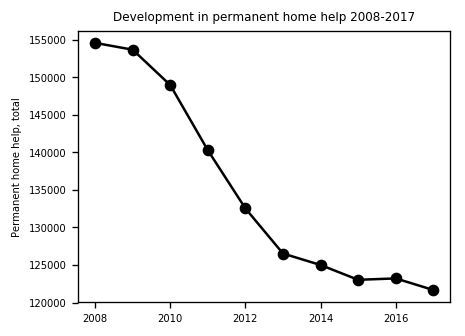

In [183]:
plt.figure(figsize=(4,3), dpi=120) 

plt.plot('year', 'home_help_total', 'ko-', data=data_final_a)
plt.title('Development in permanent home help 2008-2017')
plt.ylabel('Permanent home help, total')
plt.rc('font', size=6) 

In [184]:
data_final_a.groupby(['year']).home_help_total.mean().round(decimals=2)

year
2008    154576.5
2009    153668.4
2010    148954.9
2011    140276.0
2012    132530.4
2013    126526.2
2014    124997.0
2015    123026.5
2016    123210.7
2017    121670.7
Name: home_help_total, dtype: float64

The rather large decrease in the number of recipients referral of home care has happened despite both the total number of persons age 65 and above and the fraction of the total population has been steadily increasing over the time period, which can be seen from the two figures below.

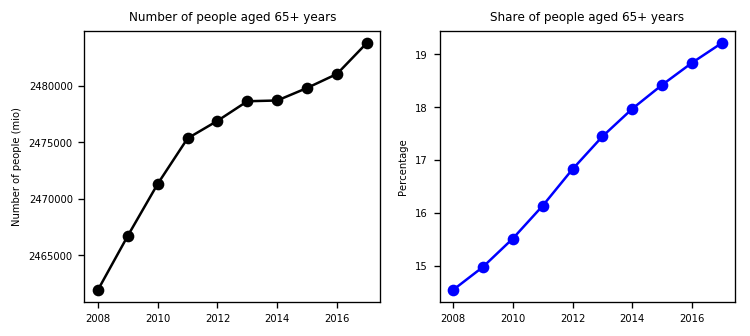

In [185]:
plt.figure(figsize=(7,3), dpi=120)

plt.subplot(1, 2, 1)
plt.plot('year', 'total', 'ko-', data=popdata)
plt.title('Number of people aged 65+ years')
plt.ylabel('Number of people (mio)')
plt.rc('font', size=6) 

plt.subplot(1, 2, 2)
plt.plot('year', 'share', 'bo-', data=popdata)
plt.title('Share of people aged 65+ years')
plt.ylabel('Percentage')
plt.rc('font', size=6) 

plt.show()

Furthermore, the public seems to be outsourcing more to private suppliers. In the figure below the number of recipients referrals that choose a private supplier of home care is a bit higher in 2017 then it was in 2008, but not as high as it was in 2012. A benefit from outsourcing home care is that private companies can be more effective as well as supplying faster, better and cheaper solutions than the municipality. On the other side, private companies most likely want to maximize profits, which might make private companies more focused on making the costs of home care as small as possible. This might result in private companies supplying lower quality home care. However, the municipality has to have two or three contractors that provide home care in the municipality, where one of them has to be the municipality itself. If the private companies drive down the quality of home care in order to maximize profit the elders can always choose a different provider (e.g. the municipality itself). This can help keep the quality of the home care provided by private companies at a certain level.

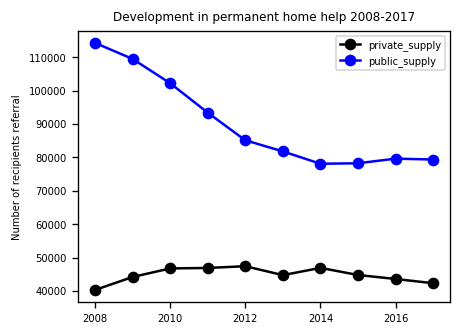

In [199]:
plt.figure(figsize=(4,3), dpi=120)

plt.plot('year', 'private_supply', 'ko-', data=data_final_a)
plt.plot('year', 'public_supply', 'bo-', data=data_final_a)
plt.title('Development in permanent home help 2008-2017')
plt.ylabel('Number of recipients referral')
plt.legend()
plt.rc('font', size=6) 

## Differences across municipalities

From the figure below it is possible to see the development of the number of recipients referral split on how many that have chosen the municipality as their supplier of home care and how many that have chosen a private supplier. Generally, most of the municipalities have experienced a decrease in the number of recipients referrals in total and in many of the municipalities there has been an increase in the number of recipients referrals that choose a private supplier. However, the level is still below the number of recipients referrals that have chosen the municipality as their supplier of home care in most of the municipalities.

The figure below does paint a somewhat mixed picture of the development of the number of recipients referral in each municipality. This is mainly due to the fact that the size of the population aged 65 years and above differ in each municipality. Taking into account the number of people aged 65 years and above could help internalize that difference. However, the development in the total number of recipients referral will still be affected by the difference between the general health of the elderly population in each municipality.

In [200]:
def plot_e(dataframe, municipality): 
    I = dataframe['municipality'] == municipality

    ax=dataframe.loc[I,:].plot(x='year', y=['private_supply','public_supply'], style=['-bo', '-ko'], figsize=(8, 5), fontsize=11, legend='False')
    ax.legend(loc='upper right', fontsize=11)
    ax.set_xlabel('Year',fontsize=11)
    ax.set_ylabel('Number of recipients referral', fontsize=11)

In [196]:
widgets.interact(plot_e, 
    dataframe = widgets.fixed(data_final_b),
    municipality = widgets.Dropdown(description='Municipality', options=data_final_b.municipality.unique(), value='Copenhagen')
);

interactive(children=(Dropdown(description='Municipality', index=11, options=('Aabenraa', 'Aalborg', 'Aarhus',…

# Conclusion

In this data project, the development of home care for the elderly in Denmark has been addressed. It has been shown that the number of people aged 65 years and above and their share of the total population has been increasing over the period 2008-2017. In the same period, the total number of recipients referral to home care has been decreasing, and further, the share that chooses a private supplier of home care has been increasing. 